In [ ]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

In [ ]:
import pandas as pd
import numpy as np
from winkie import ml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt
import datetime

import tensorflow as tf
import imblearn

In [ ]:
segmented_timeseries = np.load("segments.npy")
label_vector= np.load("label.npy")
label_names = np.load("label-names.npy")

In [ ]:
label_names

array(['back_preening', 'base', 'body_pump', 'feather_clapping',
       'front_preening', 'head_shake', 'not_defined', 'scratch_with_feet',
       'standing_shaking', 'tail_shake'], dtype='<U17')

In [ ]:
from collections import Counter

label_vector

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
decoded_y = np.argmax(label_vector, axis=1)

In [ ]:
pd.Series(decoded_y).value_counts()

1    423016
4     25444
3     10152
0      9891
8      8620
5      4159
9      3398
7      2949
2      2434
6      2111
dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTEN

oversample = SMOTEN(random_state=0)
X_over, y_over = oversample.fit_resample(segmented_timeseries, decoded_y)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
Counter(np.array([0] * 20 + [1] * 40, dtype=np.int32))

Counter({0: 20, 1: 40})

In [ ]:
Counter(decoded_y)

Counter({7: 2949,
         6: 2111,
         9: 3398,
         5: 4159,
         4: 25444,
         1: 423016,
         2: 2434,
         3: 10152,
         0: 9891,
         8: 8620})

In [ ]:
segmented_timeseries.shape

(492174, 7, 5)

In [ ]:
nsamples, nx, ny = segmented_timeseries.shape
d2_train_dataset = segmented_timeseries.reshape((nsamples,nx*ny))

In [ ]:
from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler()
x_over, y_over = oversample.fit_resample(d2_train_dataset, decoded_y)

In [ ]:
Counter(y_over)

Counter({7: 423016,
         6: 423016,
         9: 423016,
         5: 423016,
         4: 423016,
         1: 423016,
         2: 423016,
         3: 423016,
         0: 423016,
         8: 423016})

In [ ]:
x_over.shape[0]

4230160

In [ ]:
oversampled_segments = x_over.reshape(x_over.shape[0], nx, ny)
df_encoded_labels = pd.get_dummies(y_over)
label_vector = np.asarray(df_encoded_labels, dtype = np.float32)
label_vector

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Epoch 1/100
4958/4958 [==============================] - 50s 10ms/step - loss: 0.9047 - categorical_accuracy: 0.6981
Epoch 2/100
4958/4958 [==============================] - 47s 9ms/step - loss: 0.4058 - categorical_accuracy: 0.8659
Epoch 3/100
4958/4958 [==============================] - 47s 9ms/step - loss: 0.3285 - categorical_accuracy: 0.8916
Epoch 4/100
4958/4958 [==============================] - 47s 9ms/step - loss: 0.2893 - categorical_accuracy: 0.9049
Epoch 5/100
4958/4958 [==============================] - 47s 10ms/step - loss: 0.2639 - categorical_accuracy: 0.9139
Epoch 6/100
4958/4958 [==============================] - 46s 9ms/step - loss: 0.2441 - categorical_accuracy: 0.9203
Epoch 7/100
4958/4958 [==============================] - 46s 9ms/step - loss: 0.2309 - categorical_accuracy: 0.9248
Epoch 8/100
4958/4958 [==============================] - 47s 9ms/step - loss: 0.2154 - categorical_accuracy: 0.9299
Epoch 9/100
4958/4958 [==============================] - 47s 9ms/step 

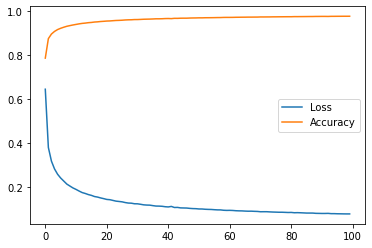

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(oversampled_segments, label_vector, test_size=0.4)

model = ml.build_model(x_train, label_vector)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
hist = model.fit(x_train,
            y_train,
            batch_size=512,
            epochs=100,
            verbose=1, callbacks=[tensorboard_callback])
    
plt.plot(hist.history['loss'], label="Loss")
plt.plot(hist.history['categorical_accuracy'], label="Accuracy")
plt.legend()
plt.show()

3305/3305 [==============================] - 12s 4ms/step - loss: 0.0639 - categorical_accuracy: 0.9807


'test loss: 0.06391407549381256\ttest accuracy: 0.980699896812439'

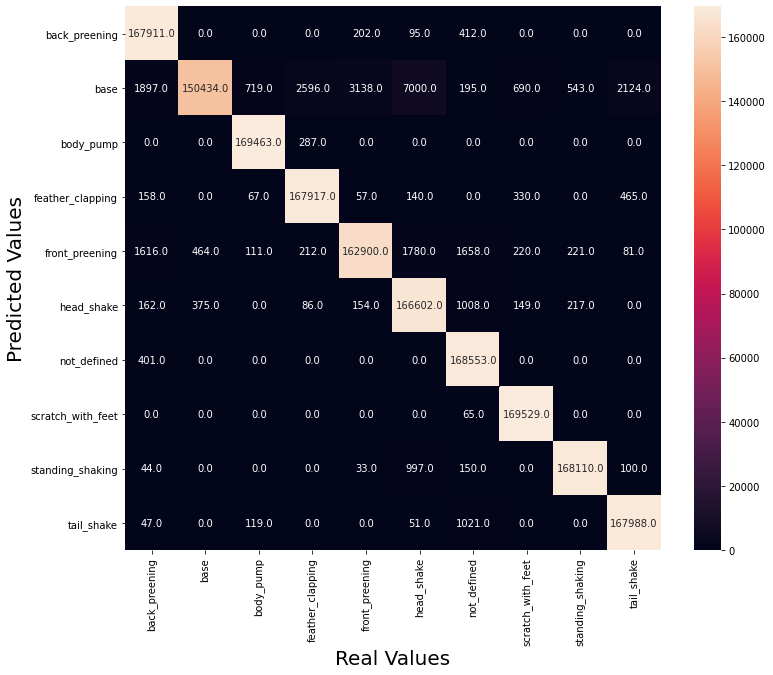

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=512)
display(f"test loss: {results[0]}\ttest accuracy: {results[1]}")


# getting predicted values for test data
y_pred = model.predict(x_test)

# matching true labels to predicted output
y_true=np.argmax(y_test, axis=1)
confusion = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

df_cm = pd.DataFrame(confusion)
plt.figure(figsize = (12,10))

sn.heatmap(df_cm, annot=True, fmt=".1f", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Real Values", fontsize=20)
plt.ylabel("Predicted Values", fontsize=20)
plt.show()

In [ ]:
model.save("model_7s-100e-512b-0015L-oversampling-sliding")

INFO:tensorflow:Assets written to: model_7s-100e-512b-0015L-oversampling-sliding\assets


In [ ]:
import pandas as pd
import numpy as np
from winkie import ml
from winkie import dlc_importer
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
import datetime
import re

features = [('head', 'x'), ('head', 'y'), ('tail', 'x'), ('left_neck', 'y'), ('right_neck', 'y')]

def build_timeseries(df, features, timeslice_length, sliding):
    "Split the data in `df` into timeseries segments of length `timeslice_length` containing given `features`."
    
    segments = []
    
    if sliding:
        step = 1
    else:
        step = timeslice_length
    
    for i in range(0, len(df) - timeslice_length + 1, step):
        s = []
        i_end = i + timeslice_length
        for f in features:
            s.append(df[f[0], f[1]].values[i:i_end])
            
        segments.append(s)

    return np.asarray(segments).reshape(-1, timeslice_length, len(features))



def apply_model_and_check_performance(model_name, result_file_name, expted_label_file_name, label_mapping, sliding=False):
    p = re.compile(r'(^[A-Za-z_]*) *= *(?:slice)? ?\((\d*), ?(\d*)\)')
    behaviours = []
    with open(expted_label_file_name) as f:
      for x in f:
        m = p.match(x)
        frames = int(m.group(3)) - int(m.group(2))
        b = m.group(1)
        behaviours += frames * [b]
    expected = pd.Series(behaviours)
    
    model = keras.models.load_model(model_name)
    
    imp = dlc_importer.DLCImporter()
    df = imp.import_hdf(result_file_name)
    df['expected'] = expected

    
    timeslice = 7
    segments = build_timeseries(df, features, timeslice, sliding=sliding)

    predictions = model.predict(segments)

    if sliding:
        classes = pd.Series(np.argmax(predictions, axis = 1))
        confidence = pd.Series(np.max(predictions, axis = 1))
    else:
        classes = pd.Series(np.argmax(predictions, axis = 1)).repeat(timeslice).reset_index(drop=True)
        confidence = pd.Series(np.max(predictions, axis = 1)).repeat(timeslice).reset_index(drop=True)

    df['class'] = classes
    df['class'] = df['class'].replace(np.NaN, 1.0)
    df['b'] = df.apply(lambda row: label_mapping[int(row['class'])], axis=1)

    df['confidence'] = confidence
    
    df_anomalies = df[(df['class'] != 1.0) & (df['class'] != -1.0)]
    df_anomalies.groupby((df_anomalies['class'].shift() != df_anomalies['class']).cumsum())

    recall = []

    for k, v in df_anomalies.groupby((df_anomalies['class'].shift() != df_anomalies['class']).cumsum()):
        recall.append([
            v['b'].head(1).values[0], 
            v['expected'].unique(), 
            v['expected'].head(1).values[0],
            datetime.timedelta(seconds=v.head(1).index.values[0] / 119.88),
            len(v), 
            v.head(1).index.values[0],
            v.tail(1).index.values[0]])

    df_performance = pd.DataFrame(recall, columns=['detected', 'expected', 'confidence', 'time', 'length', 'start', 'end'])
    
    return df, df_performance, predictions

<AxesSubplot:>

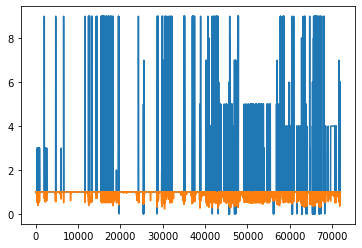

In [ ]:
label_mapping = [
    'back_preening', 'base', 'body_pump', 'feather_clapping', 'front_preening', 'head_shake', 'not_defined',
    'scratch_with_feet', 'standing_shaking', 'tail_shake']



df, df_p, pred = apply_model_and_check_performance("model_7s-100e-512b-0015L-oversampling-sliding", 
    '233_monhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5', 
    "completely_labelled_233monhabday1.txt", label_mapping, sliding=True)

df['class'].plot()
df['confidence'].plot()

In [ ]:
def calc_accuracy(df):
    ytrue = df['expected_class']
    ypred = df['class']

    metric = tf.keras.metrics.Accuracy()
    metric.update_state(ytrue, ypred)
    print(metric.result().numpy())

expected_class_lookup = {
    'eating': 1.0,
    'standing': 1.0,
    'hp': 5.0,
    'walking': 1.0,
    'fp': 4.0,
    'sf': 7.0,
    'bp': 2.0,
    'eating_flor': 1.0,
    np.NAN: 1.0
}

df['expected_class'] = df.apply(lambda row: expected_class_lookup[row['expected'][0]], axis=1)

calc_accuracy(df)

ytrue = []
for i, v in df['expected_class'].items():
    exp = [0] * 10
    exp[int(v)] = 1
    ytrue.append(exp)

metric = tf.keras.metrics.CategoricalAccuracy()
metric.update_state(ytrue[:-6], pred)
print(metric.result().numpy())

metric = tfa.metrics.F1Score(num_classes=len(ytrue[0]), threshold=None)
metric.update_state(ytrue[:-6], pred)
print(metric.result().numpy())

0.92674416
0.926738
[0.         0.9618518  0.4874372  0.         0.6148374  0.09055627
 0.         0.         0.         0.        ]


In [ ]:
df[(df['b'] == 'head_shake') & (df['confidence'] > 0.995) ]

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
40224      769.459595  263.147247   0.999999  792.666382  255.255035   
40225      769.920227  263.098511   0.999999  793.507385  254.182175   
40226      771.309326  263.732086   0.999999  794.479309  255.187561   
40227      774.824768  264.551666   0.999997  794.547913  254.980713   
40228      779.292236  267.513397   0.999991  794.006592  253.469696   
...               ...         ...        ...         ...         ...   
67300      451.538971  252.255768   1.000000  451.435059  233.861923   
67301      452.194366  252.512878   1.000000  452.220062  233.900513   
67302      450.710846  251.844009   1.000000  451.399506  234.638931   
67303      451.754517  252.075043   1.000000  451.170502  233.228790   
67304      451.689178  252.198929   1.000000  451.841248  233.585556   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
40224       0.999999  698.545532  328.609741   0.999995  774.705078  ...   
40225       1.000000  699.220886  328.228851   0.999997  776.296753  ...   
40226       0.999999  699.473083  328.940796   0.999994  776.438049  ...   
40227       0.999999  699.682922  329.230042   0.999995  777.087891  ...   
40228       0.999979  700.058289  330.448608   0.999991  779.011230  ...   
...              ...         ...         ...        ...         ...  ...   
67300       0.999184  439.189758  325.985931   1.000000  498.783234  ...   
67301       0.999168  439.000702  325.728882   1.000000  499.402863  ...   
67302       0.998763  439.575684  324.785400   1.000000  500.583557  ...   
67303       0.999073  439.948700  324.749695   1.000000  500.955139  ...   
67304       0.999030  439.459259  324.035034   1.000000  501.322723  ...   

bodyparts        body                   tail                         expected  \
coords              y likelihood           x           y likelihood             
40224      428.485901   0.999882  753.933716  598.752258   0.999996  standing   
40225      430.669678   0.999794  752.142700  599.222229   0.999982  standing   
40226      430.061829   0.999893  750.350464  599.879028   0.999960  standing   
40227      430.044861   0.999918  750.872925  599.606812   0.999986  standing   
40228      430.137207   0.999955  749.429810  600.858704   0.999957  standing   
...               ...        ...         ...         ...        ...       ...   
67300      394.013031   0.999868  609.334290  552.976196   0.999993   walking   
67301      391.962494   0.999919  608.961426  552.669861   0.999986   walking   
67302      392.502319   0.999880  605.616394  554.233459   0.999979   walking   
67303      392.912842   0.999803  603.063843  556.362427   0.999968   walking   
67304      390.803314   0.999799  602.461243  556.638062   0.999972   walking   

bodyparts class           b confidence expected_class  
coords                                                 
40224       5.0  head_shake   0.996511            1.0  
40225       5.0  head_shake   0.997795            1.0  
40226       5.0  head_shake   0.997597            1.0  
40227       5.0  head_shake   0.998071            1.0  
40228       5.0  head_shake   0.997435            1.0  
...         ...         ...        ...            ...  
67300       5.0  head_shake   0.996256            1.0  
67301       5.0  head_shake   0.996019            1.0  
67302       5.0  head_shake   0.995290            1.0  
67303       5.0  head_shake   0.995100            1.0  
67304       5.0  head_shake   0.996488            1.0  

[95 rows x 41 columns]

0.80075634
0.8007397
[0.33920705 0.88815725 0.         0.         0.46221304 0.02070971
 0.         0.         0.         0.        ]


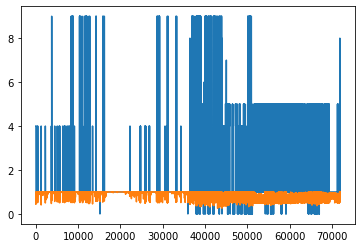

In [ ]:
df, df_p, pred = apply_model_and_check_performance("model_7s-100e-512b-0015L-oversampling-sliding", 
    '239_control2_gopro_cut_day4DLC_resnet50_goprovrJul24shuffle1_1030000.h5', 
    "completely_labelled_239_control2_gopro_cut_day4.txt", label_mapping, sliding=True)

df['class'].plot()
df['confidence'].plot()

expected_class_lookup = {
    'eating': 1.0,
    'standing': 1.0,
    'hp': 5.0,
    'walking': 1.0,
    'fp': 4.0,
    'sf': 7.0,
    'bp': 2.0,
    'eating_flor': 1.0,
    'backp': 0.0,
    np.NAN: 1.0
}

df['expected_class'] = df.apply(lambda row: expected_class_lookup[row['expected'][0]], axis=1)

calc_accuracy(df)

ytrue = []
for i, v in df['expected_class'].items():
    exp = [0] * 10
    exp[int(v)] = 1
    ytrue.append(exp)

metric = tf.keras.metrics.CategoricalAccuracy()
metric.update_state(ytrue[:-6], pred)
print(metric.result().numpy())

metric = tfa.metrics.F1Score(num_classes=len(ytrue[0]), threshold=None)
metric.update_state(ytrue[:-6], pred)
print(metric.result().numpy())